# Práce
Vypočítá se jako:

$$
W_{12}= \int_{\vec{r1}}^{\vec{r2}} \vec{F} d\vec{r}
$$
Kde $\vec{r1}$ a $\vec{r2}$ představují počáteční polohy těles. Práci konáme vždy určitém směru a podílí se na ní tedy síly, které směřují ve směru pohybu. 
## Výkon
Změna práce za čas
$$
P = \frac{dW}{dt}
$$
## Kinetická energie
$$
E_{k} = \frac{1}{2} mv^{2}
$$
## Potenciální energie
$$
E_{p} = mgh
$$
Nezávisí u ní na trajektorii - podobně jako u potenciální energie jiných polí.
## ZZE
Vychází ze symetrie fyzikálních zákonů vůči posunutí v čase
## ZZH
Vychází ze symetrie zákonů vůči posunutí v prostoru. 

Více ve Feynmannovi v kapitole 22 - vypsat

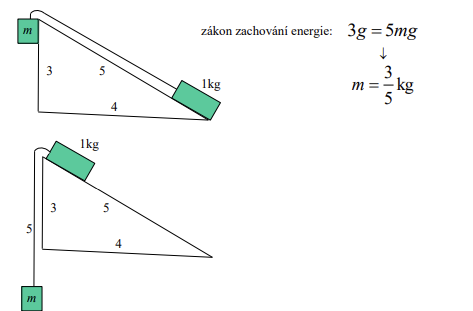


# Ukázka aplikace ZZH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from itertools import combinations
from matplotlib import animation
from matplotlib.animation import PillowWriter

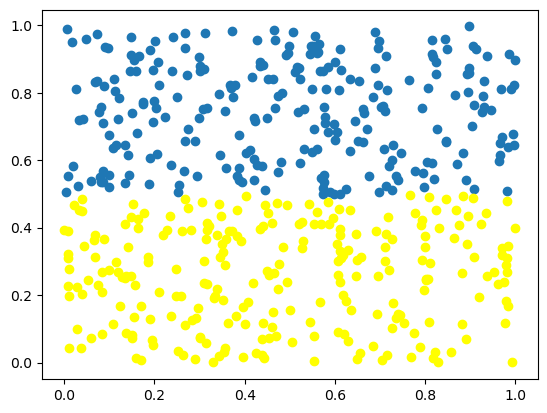

In [2]:
n_particles = 500
r = np.random.random((2,n_particles)) #inicializace pozice - rovnoměrné rozdělení
up_particles = r[1]>0.5 #True false pole
down_particles = r[1]<=0.5 #True false pole
plt.scatter(r[0][up_particles],r[1][up_particles])
plt.scatter(r[0][down_particles],r[1][down_particles],c="yellow")
# rozdělíme na hezčí srážky - pošleme je proti sobě

In [3]:
v = np.zeros((2,n_particles))
v[1][up_particles] = -500 #dolů
v[1][down_particles] = 500 # nahorů
ids = np.arange(n_particles)
particle_pair = np.asarray(list(combinations(ids,2))) #pro všehny částice jsem si vytvořil dvojice a přiřadil jim vzájemné polohy
x_pairs = np.asarray(list(combinations(r[0],2)))
y_pairs = np.asarray(list(combinations(r[1],2)))
dx_pairs = np.diff(x_pairs,axis=1).ravel()
dy_pairs = np.diff(y_pairs,axis=1).ravel()

d_pairs = np.sqrt(dx_pairs**2 + dy_pairs**2)

col_radius = 0.02
pairs_collide = particle_pair[d_pairs <2*col_radius]

v_1 = v[:,pairs_collide[:,0]] # soubor všech první částic ve srážkách
v_2 = v[:,pairs_collide[:,1]] # soubor všech druhých částic ve srážkách
r1 = r[:,pairs_collide[:,0]]
r2 = r[:,pairs_collide[:,1]]

# převedení na matice

v1new = v_1 - ((v_1-v_2)*(r1-r2)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v_2 - ((v_1-v_2)*(r1-r2)).sum(axis=0)/np.sum((r2-r1)**2, axis=0) * (r2-r1)

$$
v_{1}' = v_{1} - \frac{(v_{1}-v_{2})\dot (r_{1}-r_{2})}{|r_{1}-r_{2}|^{2}}(r_{1}-r_{2})
$$

$$
v_{2}' = v_{2} - \frac{(v_{2}-v_{1})\dot (r_{2}-r_{1})}{|r_{2}-r_{1}|^{2}}(r_{2}-r_{1})
$$
První část obou rovnic představuje výpočet relativních rychlostí obou částic dohromady. Vektor $r_{2}-r_{1}$ potom dodává směr po srážce

In [4]:
def get_delta_pairs(x, ids_pairs):
    return np.diff(np.array([x[ids_pairs[:,0]], x[ids_pairs[:,1]]]).T, axis=1).ravel()

def get_deltad_pairs(r, ids_pairs):
    return np.sqrt(get_delta_pairs(r[0], ids_pairs)**2 + get_delta_pairs(r[1], ids_pairs)**2)

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1,ts):
        ic = id_pairs[get_deltad_pairs(r, particle_pair) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -np.abs(v[0,r[0]>1])
        v[0,r[0]<0] = np.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -np.abs(v[1,r[1]>1])
        v[1,r[1]<0] = np.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

radius = 0.03
rs, vs = motion(r, v, particle_pair, ts=1000, dt=0.000008, d_cutoff=2*radius)

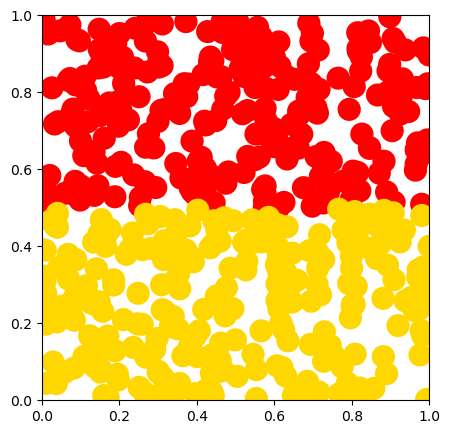

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred = rs[i][0][up_particles], rs[i][1][up_particles]
    xblue, yblue = rs[i][0][down_particles],rs[i][1][down_particles]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='gold')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('srážky.gif',writer='pillow',fps=30,dpi=100)